In [ ]:
# mount drive https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
# login with your google account and type authorization code to mount on your google drive.
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=3dd6d60630fd13ad7cbc11ce759e35d9ce1444effabd8b0b47edebfd63e5464f
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
## 학습 코드
import numpy as np
import json
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, utils
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from imblearn.over_sampling import SMOTE
import pickle
from torch.optim.lr_scheduler import StepLR
import gc
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Mydataset2(Dataset):
    def __init__(self,imgs,metadatas,answers,transform=None):
        self.imgs=imgs
        self.metadatas=metadatas
        self.answers=answers
        self.transform=transform

    def __len__(self):
        return len(self.metadatas)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image=self.imgs[idx]
        if self.transform:
            image = self.transform(image)
        metadata=self.metadatas[idx]
        diagnose=self.answers[idx]

        image = image.to(device)
        metadata = metadata.to(device)
        diagnose = diagnose.to(device)
        
        sample = {'image': image, 'metadata': metadata, 'diagnose': diagnose}

        return sample

In [ ]:
landmarks_frame=pd.read_csv('/content/drive/My Drive/2020Fall/인공개 팀플/jpeg-melanoma-256x256/csv/train_no_unknown.csv')
diagnose_dict = {"melanoma": 0, "nevus": 1}

sex = np.array(landmarks_frame.iloc[:, 2])
sex=np.where(sex=="male", 0, 1)
sex_o = np.zeros((sex.size, sex.max()+1))
sex_o[np.arange(sex.size),sex] = 1
#print('sex_o',sex_o,sex_o.shape)
sex_o=torch.from_numpy(sex_o.astype(np.float32))

age = np.array(landmarks_frame.iloc[:, 3])/10
age=age.astype(np.int64)
age_o = np.zeros((age.size, age.max()+1))
age_o[np.arange(age.size),age] = 1
age_o=torch.from_numpy(age_o.astype(np.float32))

site_dict={"head/neck":0,"upper extremity":1,"lower extremity":2,"torso":3,"palms/soles":4,"oral/genital":5}
site = np.array(landmarks_frame.iloc[:, 4])
for i in site_dict.keys():
    site=np.where(site==i,site_dict[i],site)
site=site.astype(np.int64)
site_o = np.zeros((site.size, site.max()+1))
site_o[np.arange(site.size),site] = 1
site_o=torch.from_numpy(site_o.astype(np.float32))

metadata=torch.cat((sex_o,age_o,site_o),1)

answers=np.array(landmarks_frame.iloc[:, 5])
answers=np.where(answers=="melanoma", 0, 1)
answers=torch.from_numpy(answers)

images=[]
ids=landmarks_frame.iloc[:, 0]
for i in range(metadata.size(0)): 
    st=time.time()
    img_name = os.path.join('/content/drive/My Drive/2020Fall/인공개 팀플/jpeg-melanoma-256x256/train',ids[i])
    image = io.imread(img_name+".jpg")
    image = transforms.ToTensor()(image)
    image=image.view(-1)
    im=torch.cat((image.unsqueeze(0),metadata[i:i+1]),1)
    images.append(im)

images=torch.cat(images,0)


torch.Size([5622, 18])
a torch.Size([5622])
0 34.345131158828735
100 0.4409177303314209
200 0.36239147186279297
300 0.305936336517334
400 0.5706923007965088
500 0.4772820472717285
600 0.38675475120544434
700 0.4730226993560791
800 0.3896772861480713
900 0.5065996646881104
1000 0.5626215934753418
1100 0.3677945137023926
1200 0.446810245513916
1300 0.5654134750366211
1400 0.4788217544555664
1500 0.49382686614990234
1600 0.3949582576751709
1700 0.3487114906311035
1800 0.4148285388946533
1900 0.5373029708862305
2000 0.3746156692504883
2100 0.4530456066131592
2200 0.43403077125549316
2300 0.426973819732666
2400 0.31789660453796387
2500 0.4763960838317871
2600 0.33788537979125977
2700 0.3668344020843506
2800 0.4059784412384033
2900 0.28898048400878906
3000 0.38097596168518066
3100 0.3151993751525879
3200 0.3823387622833252
3300 0.4221036434173584
3400 0.42838335037231445
3500 0.3681638240814209
3600 0.40310144424438477
3700 0.3682281970977783
3800 0.586622953414917
3900 0.3509221076965332
40

In [ ]:
#############################################
# applying SMOTE.
#############################################
gc.collect()
sm=SMOTE(random_state=0)
gc.collect()
alldata_up,answers_up=sm.fit_sample(images,answers)
gc.collect()
print('done')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


done


In [ ]:
d_up,a_up=torch.from_numpy(alldata_up),torch.from_numpy(answers_up)
imgs=d_up[:,:-18].view(d_up.size(0),3,256,256)
metadatas=d_up[:,-18:]


torch.Size([10194, 196626])
5097


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((240, 240))
    ])

train_dataset = Mydataset2(imgs,metadatas,a_up,train_transform)

print(len(train_dataset))
train_set, val_set = torch.utils.data.random_split(train_dataset, [9000,1194])
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(val_set, batch_size=16, shuffle=True, drop_last=True)

10194


In [ ]:
#############################################
# Actual framework of our model architecture.
#############################################
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        cnn_model_name = 'efficientnet-b1'
        self.cnn_model = EfficientNet.from_pretrained(cnn_model_name, num_classes=2).to(device)
        print(EfficientNet.get_image_size(cnn_model_name))
        self.cnn = nn.Sequential (                                               #EfficientNet layer for image
            nn.Linear(1280, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

        self.meta = nn.Sequential (                                              #MLP layer for metadata
            nn.Linear(18, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        ) 

        self.post = nn.Sequential (                                              #Post-process layer 
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 2)
        )

        ################################

    def forward(self, image, metadata):
        image = self.cnn_model.extract_features(image)
        
        image = nn.AdaptiveAvgPool2d(output_size=(1, 1))(image)
        image = torch.squeeze(image, -1)
        image = torch.squeeze(image, -1)
        img_out = self.cnn(image)                                               # EffieicntNet extracts features from image.
        meta_out = self.meta(metadata)                                          # Metadatas are feed into MLP layer.
        output = self.post(torch.cat((img_out, meta_out), dim = 1))             # Concat 2 outputs, and post-process to convert the output dimension into 2(nevus/melanoma).
        #######################################################################
        return output

In [ ]:
model = MyNetwork().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Loaded pretrained weights for efficientnet-b1
240
6753604


시작
epoch: 0 / training_loss : 0.519
epoch: 0 / training_accuracy : 0.749
epoch: 0 / validation_loss : 0.637
epoch: 0 / validation_accuracy : 0.647
78.51934123039246
epoch: 1 / training_loss : 0.293
epoch: 1 / training_accuracy : 0.928
epoch: 1 / validation_loss : 0.494
epoch: 1 / validation_accuracy : 0.779
78.40561652183533
epoch: 2 / training_loss : 0.200
epoch: 2 / training_accuracy : 0.967
epoch: 2 / validation_loss : 0.343
epoch: 2 / validation_accuracy : 0.863
78.35875153541565
epoch: 3 / training_loss : 0.145
epoch: 3 / training_accuracy : 0.983
epoch: 3 / validation_loss : 0.159
epoch: 3 / validation_accuracy : 0.970
78.29645252227783
epoch: 4 / training_loss : 0.111
epoch: 4 / training_accuracy : 0.990
epoch: 4 / validation_loss : 0.117
epoch: 4 / validation_accuracy : 0.975
78.30469465255737
epoch: 5 / training_loss : 0.097
epoch: 5 / training_accuracy : 0.988
epoch: 5 / validation_loss : 0.110
epoch: 5 / validation_accuracy : 0.977
78.2856137752533
epoch: 6 / training_loss :

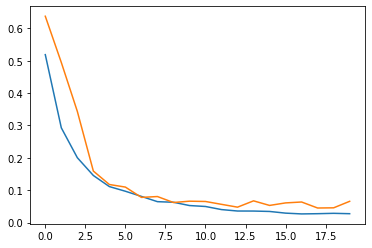

In [ ]:
#############################################
# Training code.
#############################################
learning_rate = 0.0001
epoch = 20
training_loss = 0
train_loss_list=[]
validation_loss_list=[]
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)                          #Learning rate decay to find optimal better
print("시작")
for ep in range(epoch):                                                         #Training process.
    training_loss = 0
    training_accuracy = 0
    train_num_data = 0
    model.train()
    st=time.time()
    for batch_idx, dictionary in enumerate(train_dataloader):
        x = dictionary['image']                                                 #  Send `x` and `y` to either cpu or gpu using `device` variable.
        y = dictionary['diagnose']
        meta = dictionary['metadata']

        logit = model(x, meta)                                                  # Feed `x` into the network, get an output, and keep it in a variable called `logit`. 

        accuracy = (logit.argmax(dim=1) == y).float().mean()                    # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
        loss = nn.CrossEntropyLoss()(logit, y)                                  # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
        optimizer.zero_grad()
        loss.backward()                                                         # backward the computed loss. 
        optimizer.step()                                                        # update the network weights. 
        training_loss += loss.item()*x.shape[0]
        training_accuracy += accuracy.item()*x.shape[0]
        train_num_data += x.shape[0]

    scheduler.step()
    training_loss /= train_num_data
    training_accuracy /= train_num_data
    print(f'epoch: {ep} / training_loss : {training_loss:.3f}')
    print(f'epoch: {ep} / training_accuracy : {training_accuracy:.3f}')
    train_loss_list.append(training_loss)
    
    model.eval()                                                                #Validation process. It's very similar to the training part, but not calculating gradient.
    with torch.no_grad():
        validation_loss = 0.
        validation_accuracy = 0.
        validation_num_data = 0.
        for batch_idx, dictionary in enumerate(validation_dataloader):
            x = dictionary['image']
            y = dictionary['diagnose']
            meta = dictionary['metadata']

            logit = model(x, meta)
            loss = nn.CrossEntropyLoss()(logit, y)

            accuracy = (logit.argmax(dim=1) == y).float().mean()

            validation_loss += loss.item()*x.shape[0]
            validation_accuracy += accuracy.item()*x.shape[0]
            validation_num_data += x.shape[0]

        validation_loss /= validation_num_data
        validation_accuracy /= validation_num_data
        validation_loss_list.append(validation_loss)
        print(f'epoch: {ep} / validation_loss : {validation_loss:.3f}')
        print(f'epoch: {ep} / validation_accuracy : {validation_accuracy:.3f}')
        print(time.time()-st)

plt.plot(np.arange(epoch),np.array(train_loss_list))
plt.plot(np.arange(epoch),np.array(validation_loss_list))

In [ ]:
torch.save(model.state_dict(), f'/content/drive/My Drive/2020Fall/인공개 팀플/results/smote_model_b1_20.pt')
print("model saved")

model saved
